#### 1. Import Required Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

# Google Colab file upload
from google.colab import files

#### 2. Upload and Load Dataset


In [ ]:
# Upload dataset file in Colab
uploaded = files.upload()

# Load JSON dataset line-by-line
data = []

with open("/content/News_Category_Dataset_v3.json", "r") as f:
    for line in f:
        obj = json.loads(line)
        data.append(obj)

print(f"Total records: {len(data)}")
print("First record:", data[0])

Saving News_Category_Dataset_v3.json to News_Category_Dataset_v3.json


#### 3. Data Preparation and Filtering

We restrict the dataset to only:
- POLITICS
- SPORTS


In [ ]:
# Load required columns
df = pd.read_json('/content/News_Category_Dataset_v3.json', lines=True)[['headline', 'category']]
print(df.head())
print(df.value_counts())
print(df['category'].value_counts())


                                            headline   category
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY
3  The Funniest Tweets From Parents This Week (Se...  PARENTING
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS
headline                                                          category      
Sunday Roundup                                                    POLITICS          90
The 20 Funniest Tweets From Women This Week                       WOMEN             80
Weekly Roundup of eBay Vintage Clothing Finds (PHOTOS)            STYLE & BEAUTY    59
Weekly Roundup of eBay Vintage Home Finds (PHOTOS)                HOME & LIVING     54
Watch The Top 9 YouTube Videos Of The Week                        TECH              46
                                                                                    ..
France Taxed 

In [ ]:
# Filter only Sports and Politics
categories = ['POLITICS', 'SPORTS']
df = df[df['category'].isin(categories)]
df.head()

,headline,category
17,"Maury Wills, Base-Stealing Shortstop For Dodge...",SPORTS
21,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS
24,‘Beautiful And Sad At The Same Time’: Ukrainia...,POLITICS
26,"Las Vegas Aces Win First WNBA Title, Chelsea G...",SPORTS
30,Biden Says Queen's Death Left 'Giant Hole' For...,POLITICS


In [ ]:
df.shape

(40679, 2)

#### 4. Exploratory Data Analysis (EDA)

##### Class Distribution


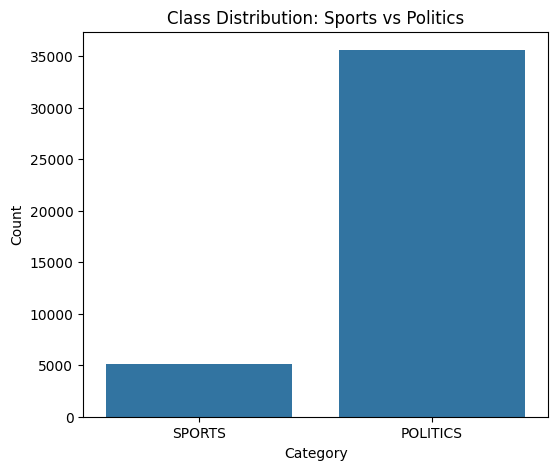

In [ ]:
df['category'].value_counts()

plt.figure(figsize=(6,5))
sns.countplot(x='category', data=df)
plt.title("Class Distribution: Sports vs Politics")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [ ]:
df['category_num'] = df['category'].map({
    'POLITICS': 0,
    'SPORTS': 1
})


##### Headline Length Analysis


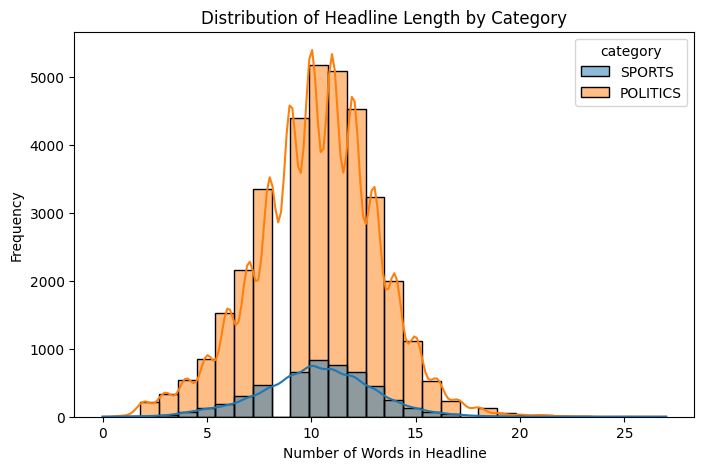

Average headline length per class:
category
POLITICS    10.258834
SPORTS      10.266299
Name: headline_length, dtype: float64


In [ ]:
# Calculate headline length
df['headline_length'] = df['headline'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='headline_length', hue='category', bins=30, kde=True)
plt.title("Distribution of Headline Length by Category")
plt.xlabel("Number of Words in Headline")
plt.ylabel("Frequency")
plt.show()

print("Average headline length per class:")
print(df.groupby('category')['headline_length'].mean())


#### 5. Text Preprocessing

Steps:
- Tokenization
- Lemmatization
- Stopword removal
- Punctuation removal


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)

df['preprocessed_txt'] = df['headline'].apply(preprocess)


In [ ]:
from collections import Counter


# Top Frequent Words per Category

def get_top_words(text_series, n=15):
    all_words = " ".join(text_series).split()
    counter = Counter(all_words)
    return counter.most_common(n)

print("Top words in Politics:")
print(get_top_words(df[df['category']=='POLITICS']['preprocessed_txt']))

print("\nTop words in Sports:")
print(get_top_words(df[df['category']=='SPORTS']['preprocessed_txt']))


Top words in Politics:
[('Trump', 8609), ('Donald', 3122), ('GOP', 1927), ('Clinton', 1756), ('say', 1661), ('Obama', 1618), ('trump', 1430), ('New', 1333), ('House', 1328), ('Hillary', 1304), ('U.S.', 1016), ('White', 958), ('Court', 874), ('Senate', 830), ('Republicans', 808)]

Top words in Sports:
[('NFL', 362), ('Game', 232), ('VIDEO', 221), ('World', 200), ('Player', 180), ('Football', 179), ('Team', 175), ('NBA', 172), ('Olympic', 166), ('U.S.', 157), ('Olympics', 154), ('Bowl', 146), ('win', 145), ('say', 142), ('Super', 141)]


#### 6. Train-Test Split


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['preprocessed_txt'],    # features
    df['category_num'],        # labels
    test_size=0.2,             # 20% test
    random_state=42,           # for reproducibility
    stratify=df['category_num']# maintain balance of classes
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 32543
Test size: 8136


#### 7. Feature Extraction using TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [ ]:
# Optional: Bag-of-Words for comparison
bow_vectorizer = CountVectorizer(ngram_range=(1,1), max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)


#### 8. Model Training and Comparison

We evaluate:
- Naive Bayes
- Logistic Regression
- Linear SVM


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Politics','Sports']))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=['Politics','Sports'],
                yticklabels=['Politics','Sports'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model, y_pred, acc, precision, recall, f1


In [ ]:
results = {}


--- Naive Bayes (TF-IDF) ---
Accuracy: 0.9565
              precision    recall  f1-score   support

    Politics       0.96      1.00      0.98      7121
      Sports       0.96      0.68      0.80      1015

    accuracy                           0.96      8136
   macro avg       0.96      0.84      0.89      8136
weighted avg       0.96      0.96      0.95      8136



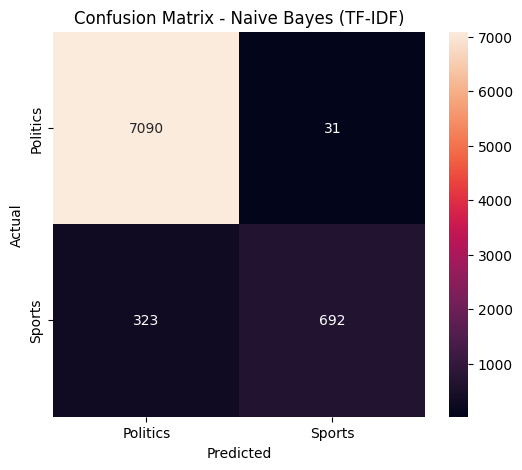

In [ ]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model, y_pred_nb, acc_nb, prec_nb, rec_nb, f1_nb = evaluate_model(
    nb_model, X_train_vec, y_train, X_test_vec, y_test,
    "Naive Bayes (TF-IDF)"
)
results["Naive Bayes"] = [acc_nb, prec_nb, rec_nb, f1_nb]


--- Logistic Regression (TF-IDF) ---
Accuracy: 0.9522
              precision    recall  f1-score   support

    Politics       0.95      0.99      0.97      7121
      Sports       0.95      0.65      0.77      1015

    accuracy                           0.95      8136
   macro avg       0.95      0.82      0.87      8136
weighted avg       0.95      0.95      0.95      8136



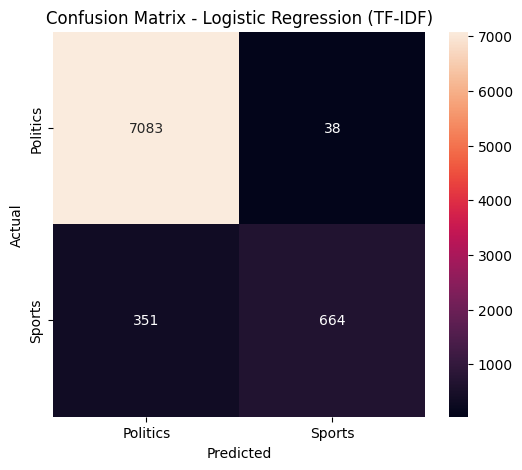

In [ ]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)

lr_model, y_pred_lr, acc_lr, prec_lr, rec_lr, f1_lr = evaluate_model(
    lr_model,
    X_train_vec,
    y_train,
    X_test_vec,
    y_test,
    "Logistic Regression (TF-IDF)"
)

results["Logistic Regression"] = [acc_lr, prec_lr, rec_lr, f1_lr]




--- Linear SVM (TF-IDF) ---
Accuracy: 0.9695
              precision    recall  f1-score   support

    Politics       0.97      0.99      0.98      7121
      Sports       0.93      0.82      0.87      1015

    accuracy                           0.97      8136
   macro avg       0.95      0.91      0.93      8136
weighted avg       0.97      0.97      0.97      8136



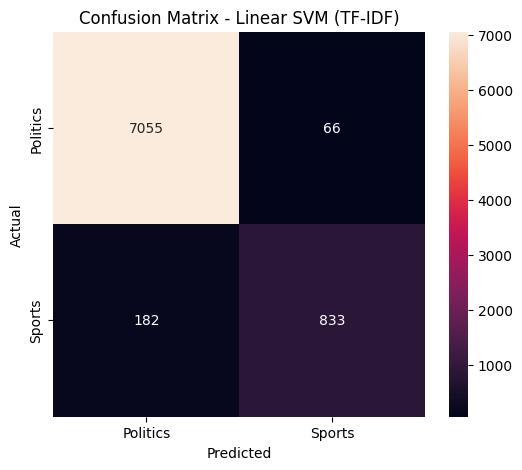

In [ ]:
# Linear SVM
svm_model = LinearSVC()
svm_model, y_pred_svm, acc_svm, prec_svm, rec_svm, f1_svm = evaluate_model(
    svm_model, X_train_vec, y_train, X_test_vec, y_test,
    "Linear SVM (TF-IDF)"
)
results["Linear SVM"] = [acc_svm, prec_svm, rec_svm, f1_svm]

In [ ]:
models = {
    "Naive Bayes": nb_model,
    "Logistic Regression": lr_model,
    "Linear SVM": svm_model
}


#### 9. Model Performance Comparison


In [ ]:
comparison_df = pd.DataFrame(results,
                             index=["Accuracy", "Precision", "Recall", "F1-Score"]).T

print("\nFull Model Comparison:")
print(comparison_df)



Full Model Comparison:
                     Accuracy  Precision    Recall  F1-Score
Naive Bayes          0.956490   0.957123  0.681773  0.796318
Linear SVM           0.969518   0.926585  0.820690  0.870428
Logistic Regression  0.952188   0.945869  0.654187  0.773442


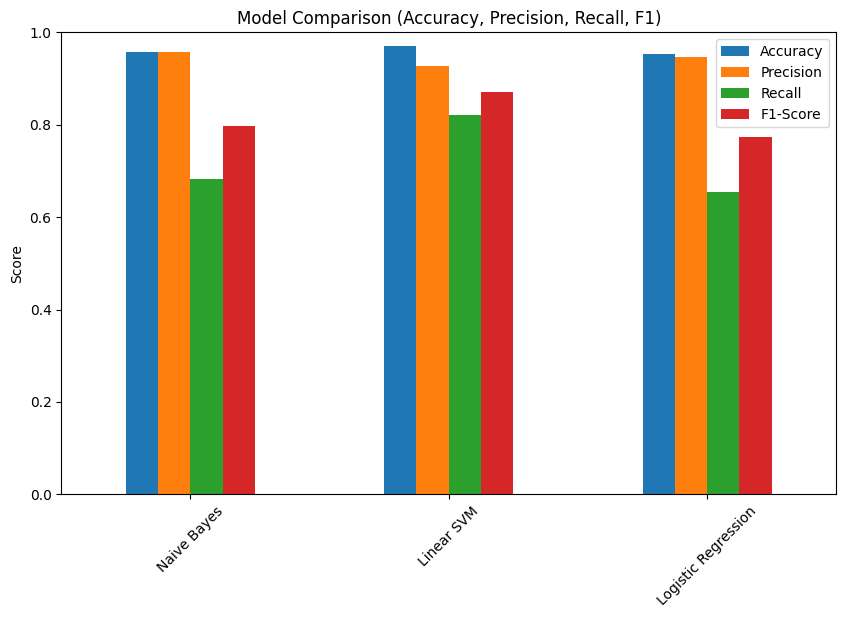

In [ ]:
comparison_df.plot(kind='bar', figsize=(10,6))
plt.title("Model Comparison (Accuracy, Precision, Recall, F1)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()



#### 10. Interactive Prediction


In [ ]:
label_map = {0: "Politics", 1: "Sports"}

def predict_headline(text, model, vectorizer):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    clean_text = " ".join(tokens)

    vect_text = vectorizer.transform([clean_text])
    pred = model.predict(vect_text)[0]

    return label_map[pred]

# Interactive loop
while True:
    user_input = input("\nEnter a headline (type 'exit' to quit): ")

    if user_input.lower() == 'exit':
        break

    print("\nPredictions:")

    for model_name, model in models.items():
        prediction = predict_headline(user_input, model, vectorizer)
        print(f"{model_name}: {prediction}")



Predictions:
Naive Bayes: Politics
Logistic Regression: Politics
Linear SVM: Politics
